In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h3pandas
from tqdm import tqdm

In [3]:
season = 'spring'
comb = pd.read_csv(f'../../data/D04.greentrace_thermotrace/Trophic_Niche_Invertivore_10_100_30_80_curve_query.csv')
comb = comb[comb['season']=='spring']

try:
    del comb['geometry']
except:
    pass
comb = comb.set_index('h3_02').h3.h3_to_geo_boundary().reset_index(drop=False)
comb = comb[comb.area<200]

######## 
comb['BirdWave_mean_DOY'] = comb['mean_DOY_peak']
comb['BirdWave_std_DOY'] = comb['std_DOY_peak']
comb['GreenWave_mean_DOY'] = comb[f'expected_trace_by_delta_NDVI']
comb['Temp_mean_DOY'] = comb[f'expected_trace_by_tmean']
comb = comb.dropna(subset=['GreenWave_mean_DOY','Temp_mean_DOY'])

def get_centered_GreenWave_mean_DOY(df):
    df['centered_GreenWave_mean_DOY'] = df['GreenWave_mean_DOY']-df['GreenWave_mean_DOY'].mean()
    return df

def get_centered_Temp_mean_DOY(df):
    df['centered_Temp_mean_DOY'] = df['Temp_mean_DOY']-df['Temp_mean_DOY'].mean()
    return df

comb = comb.groupby('h3_02').apply(get_centered_GreenWave_mean_DOY).reset_index(drop=True)
comb = comb.groupby('h3_02').apply(get_centered_Temp_mean_DOY).reset_index(drop=True)


/tmp/ipykernel_9224/2585649282.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  comb = comb[comb.area<200]
/tmp/ipykernel_9224/2585649282.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comb = comb.groupby('h3_02').apply(get_centered_GreenWave_mean_DOY).reset_index(drop=True)
/tmp/ipykernel_9224/2585649282.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude 

In [9]:
def reg_phenological_shift(df):
    import statsmodels.api as sm
    df = df.dropna(subset=['mean_DOY_peak','year'])
    if len(df) <= 5:
        return None

    X = sm.add_constant(df['year'])
    y = df['mean_DOY_peak']
    global model
    model = sm.OLS(y, X).fit()
    model = model.get_robustcov_results()
    
    return pd.Series({'shift_rate':model.params[1], 'CI_left':model.conf_int()[1,0], 'CI_right':model.conf_int()[1,1]})


res = comb.groupby(['h3_02', 'lat', 'lng']).apply(reg_phenological_shift)
res = pd.DataFrame(res).reset_index(drop=False)


/tmp/ipykernel_9224/3703557542.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res = comb.groupby(['h3_02', 'lat', 'lng']).apply(reg_phenological_shift)


In [10]:
res

,h3_02,lat,lng,shift_rate,CI_left,CI_right
0,820007fffffffff,79.251775,38.027955,5.505435,0.666900,10.343969
1,82001ffffffffff,81.038483,50.523675,6.285832,3.993209,8.578455
2,820027fffffffff,77.193999,29.600681,-0.028283,-5.109697,5.053131
3,82002ffffffffff,79.658404,22.595539,0.791173,-4.834629,6.416974
4,82004ffffffffff,84.361267,-34.798344,1.673554,-1.646764,4.993871
...,...,...,...,...,...,...
2136,82df5ffffffffff,-53.446771,-62.048788,-0.031951,-2.364176,2.300274
2137,82df67fffffffff,-56.300212,-70.665291,2.631822,-2.028309,7.291954
2138,82df6ffffffffff,-53.615498,-70.212764,0.660835,-3.411491,4.733160
2139,82e097fffffffff,-50.143201,70.656410,-1.300728,-5.070359,2.468903


100%|██████████| 1550/1550 [00:10<00:00, 145.51it/s]


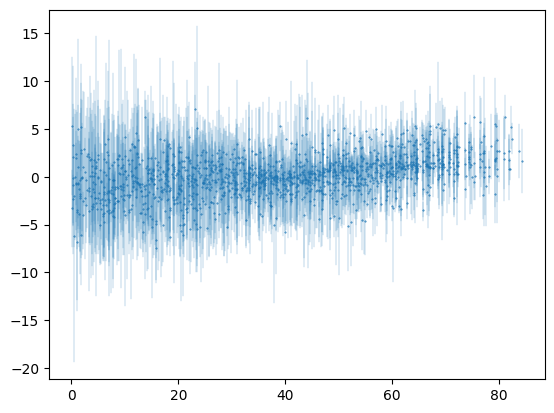

In [11]:


for index, line in tqdm(res[res['lat']>=0].iterrows(), total=len(res[res['lat']>=0])):

    plt.scatter(
        line['lat'],line['shift_rate'], s=0.2, c='tab:blue'
    )
    plt.plot(
        [line['lat'], line['lat']],[line['CI_left'], line['CI_right']], linewidth=0.2, c='tab:blue'
    )
    
    


/tmp/ipykernel_12217/3861428431.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res1 = comb.groupby(['h3_02','lat']).apply(reg1).reset_index(drop=False)
/tmp/ipykernel_12217/3861428431.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res2 = comb.groupby(['h3_02','lat']).apply(reg2).reset_index(drop=False)


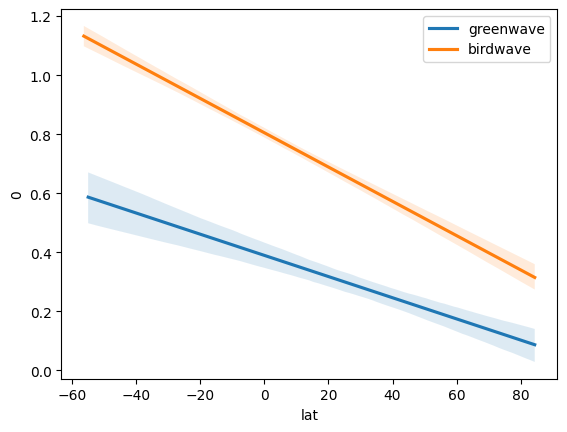

In [15]:
def reg1(df):
    import statsmodels.api as sm
    df = df.dropna(subset=['expected_greenwave_cue_arrival_by_tmean','centered_GreenWave_mean_DOY'])
    if len(df) <= 5:
        return None

    X = sm.add_constant(df['expected_greenwave_cue_arrival_by_tmean'])
    y = df['centered_GreenWave_mean_DOY']
    model = sm.OLS(y, X).fit()
    model = model.get_robustcov_results()
    return model.params[1]

def reg2(df):
    import statsmodels.api as sm
    df = df.dropna(subset=['centered_Temp_mean_DOY','BirdWave_mean_DOY'])
    if len(df) <= 5:
        return None

    X = sm.add_constant(df['centered_Temp_mean_DOY'])
    y = df['BirdWave_mean_DOY']
    model = sm.OLS(y, X).fit()
    model = model.get_robustcov_results()
    return model.params[1]

res1 = comb.groupby(['h3_02','lat']).apply(reg1).reset_index(drop=False)

fig,ax = plt.subplots()
import seaborn as sns 
sns.regplot(x=res1['lat'], y=res1[0], ax=ax, label='greenwave', scatter=False)

res2 = comb.groupby(['h3_02','lat']).apply(reg2).reset_index(drop=False)
import seaborn as sns 
sns.regplot(x=res2['lat'], y=res2[0], ax=ax, label='birdwave', scatter=False)

plt.legend()
plt.show()



/tmp/ipykernel_17623/1642513532.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res1 = comb[(comb['lat']>=0) & (comb['lng']<=-30)].groupby(['h3_02','lat']).apply(reg1).reset_index(drop=False)
/tmp/ipykernel_17623/1642513532.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res2 = comb[(comb['lat']>=0) & (comb['lng']<=-30)].groupby(['h3_02','lat']).apply(reg2).reset_index(drop=False)


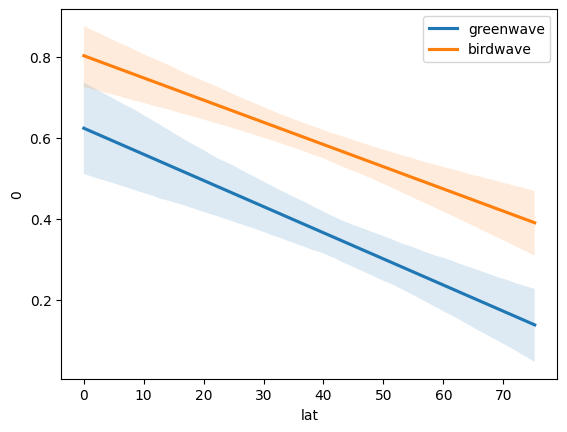

In [21]:
def reg1(df):
    import statsmodels.api as sm
    df = df.dropna(subset=['centered_Temp_mean_DOY','centered_GreenWave_mean_DOY'])
    if len(df) <= 5:
        return None

    X = sm.add_constant(df['centered_Temp_mean_DOY'])
    y = df['centered_GreenWave_mean_DOY']
    model = sm.OLS(y, X).fit()
    model = model.get_robustcov_results()
    return model.params[1]

def reg2(df):
    import statsmodels.api as sm
    df = df.dropna(subset=['centered_Temp_mean_DOY','BirdWave_mean_DOY'])
    if len(df) <= 5:
        return None

    X = sm.add_constant(df['centered_Temp_mean_DOY'])
    y = df['BirdWave_mean_DOY']
    model = sm.OLS(y, X).fit()
    model = model.get_robustcov_results()
    return model.params[1]

res1 = comb[(comb['lat']>=0) & (comb['lng']<=-30)].groupby(['h3_02','lat']).apply(reg1).reset_index(drop=False)

fig,ax = plt.subplots()
import seaborn as sns 
sns.regplot(x=res1['lat'], y=res1[0], ax=ax, label='greenwave', scatter=False)

res2 = comb[(comb['lat']>=0) & (comb['lng']<=-30)].groupby(['h3_02','lat']).apply(reg2).reset_index(drop=False)
import seaborn as sns 
sns.regplot(x=res2['lat'], y=res2[0], ax=ax, label='birdwave', scatter=False)

plt.legend()
plt.show()



In [22]:
comb_NA = comb[(comb['lat']>=0) & (comb['lng']<=-30)]

In [28]:
def reg1(df):
    import statsmodels.api as sm
    df = df.dropna(subset=['centered_Temp_mean_DOY','BirdWave_mean_DOY'])
    if len(df) <= 5:
        return None

    X = sm.add_constant(df['centered_Temp_mean_DOY'])
    y = df['BirdWave_mean_DOY']
    model = sm.OLS(y, X).fit()
    model = model.get_robustcov_results()
    return model.params[1]

res = comb_NA.groupby(['h3_02','lng','lat']).apply(reg1, include_groups=False).reset_index(drop=False)


<Axes: >

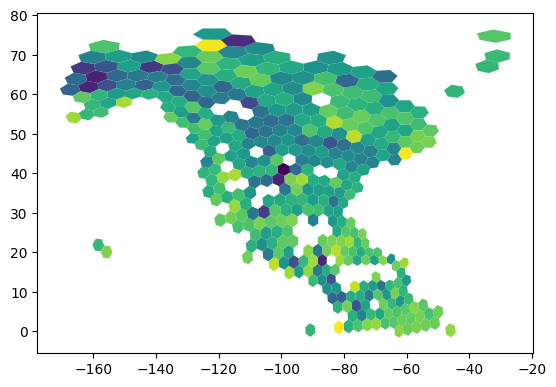

In [40]:
res[res[0]<1.5].set_index('h3_02').h3.h3_to_geo_boundary().plot(0)

<Axes: xlabel='lat', ylabel='0'>

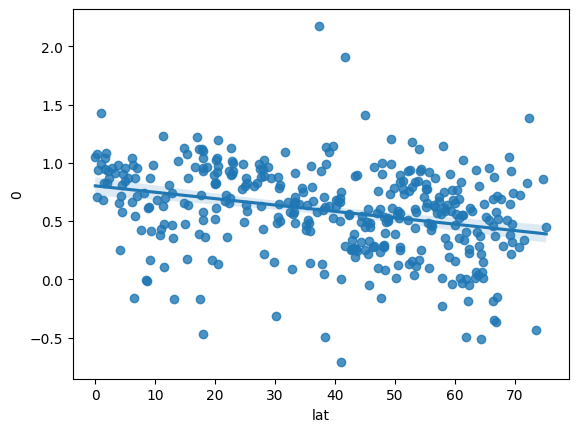

In [34]:
sns.regplot(
    x= res['lat'],
    y = res[0],
)


## Check whether frequentist way the NA mismatch also increase with latitude

In [45]:
import glob
all_niche_list = glob.glob('../../data/D03.greentrace_thermotrace/Trophic_Niche_*_10_40_20_50_curve_query.csv')
all_niche_list = [i.split('thermotrace/')[-1].split('_10_40')[0] for i in all_niche_list]
all_niche_list

['Trophic_Niche_Scavenger',
 'Trophic_Niche_Nectarivore',
 'Trophic_Niche_Invertivore',
 'Trophic_Niche_Granivore',
 'Trophic_Niche_Herbivore_terrestrial',
 'Trophic_Niche_Herbivore_aquatic',
 'Trophic_Niche_Omnivore',
 'Trophic_Niche_Frugivore',
 'Trophic_Niche_Vertivore',
 'Trophic_Niche_Aquatic_predator']

In [97]:
all_comb_list = []
for niche in all_niche_list:
    
    season = 'spring'
    comb = pd.read_csv(f'../../data/D03.greentrace_thermotrace/{niche}_10_40_20_50_curve_query.csv')
    comb = comb[comb['season']=='spring']

    try:
        del comb['geometry']
    except:
        pass
    comb = comb.set_index('h3_02').h3.h3_to_geo_boundary().reset_index(drop=False)
    comb = comb[comb.area<200]

    ######## 
    comb['BirdWave_mean_DOY'] = comb['mean_DOY_peak']
    comb['BirdWave_std_DOY'] = comb['std_DOY_peak']
    comb['GreenWave_mean_DOY'] = comb[f'Exp_{season}_DOY_by_delta_NDVI']
    comb['Temp_mean_DOY'] = comb[f'Exp_{season}_DOY_by_tmean']
    comb = comb.dropna(subset=['GreenWave_mean_DOY','Temp_mean_DOY'])

    def get_centered_GreenWave_mean_DOY(df):
        # print(df)
        df['centered_GreenWave_mean_DOY'] = df['GreenWave_mean_DOY']-df['GreenWave_mean_DOY'].mean()
        return df

    def get_centered_Temp_mean_DOY(df):
        df['centered_Temp_mean_DOY'] = df['Temp_mean_DOY']-df['Temp_mean_DOY'].mean()
        return df

    comb = comb.groupby(['h3_02']).apply(get_centered_GreenWave_mean_DOY, include_groups=False).reset_index(drop=False)
    del comb['level_1']
    comb = comb.groupby(['h3_02']).apply(get_centered_Temp_mean_DOY, include_groups=False).reset_index(drop=False)
    del comb['level_1']
    comb['niche'] = niche
    all_comb_list.append(comb)

all_comb = pd.concat(all_comb_list, axis=0).reset_index(drop=True)
del all_comb_list


/tmp/ipykernel_17623/1386377774.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  comb = comb[comb.area<200]
/tmp/ipykernel_17623/1386377774.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  comb = comb[comb.area<200]
/tmp/ipykernel_17623/1386377774.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  comb = comb[comb.area<200]
/tmp/ipykernel_17623/1386377774.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  comb = comb[comb.area<200]
/tmp

In [98]:
all_comb = all_comb[(all_comb['lat']>0) & (all_comb['lng']<=-30)]
all_comb['lat_abs'] = all_comb['lat'].abs()

In [117]:
res = all_comb.groupby(['h3_02','niche','lat','lng'])['mean_DOY_peak'].std().reset_index(drop=False)
res = res.rename(columns={'mean_DOY_peak':'variation_of_mean_DOY_peak'})

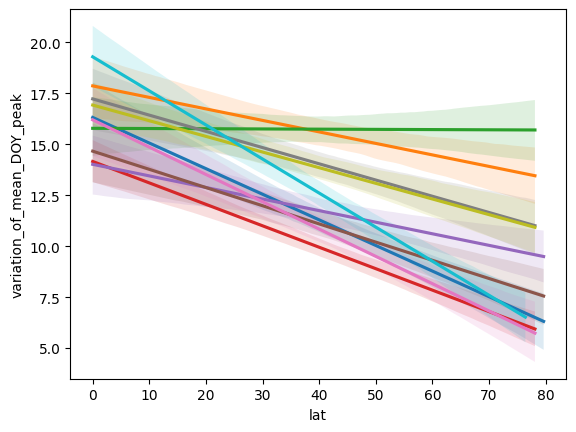

In [120]:
for niche in res.niche.unique():
    tmp = res[res['niche']==niche]
    # tmp = tmp[tmp['lat']>=25]
    sns.regplot(tmp['lat'], tmp['variation_of_mean_DOY_peak'], 
                scatter=False,
                scatter_kws={'s':0.2,'alpha':0.2}, label=niche)
    


In [99]:
# Calc thermowave sensitivity
def calc_sensitivity(tmp):
    import statsmodels.api as sm
    tmp = tmp.dropna(subset=['Exp_spring_DOY_by_tmean','mean_DOY_peak'])
    if len(tmp)<5:
        return None
    X = sm.add_constant(tmp['Exp_spring_DOY_by_tmean'])
    y = tmp['mean_DOY_peak']
    model = sm.OLS(y, X).fit()
    res = model.get_robustcov_results()
    return res.params[1]


In [100]:
res = all_comb.groupby(['niche','h3_02','lng','lat']).apply(calc_sensitivity).reset_index(drop=False)
res = res.rename(columns={0:'thermowave_sensitivity_unstded'})


/tmp/ipykernel_17623/1001841473.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res = all_comb.groupby(['niche','h3_02','lng','lat']).apply(calc_sensitivity).reset_index(drop=False)


In [101]:
res = res.dropna()
sensitivity_df = res


In [104]:
sensitivity_df

,niche,h3_02,lng,lat,thermowave_sensitivity_unstded
2,Trophic_Niche_Aquatic_predator,82028ffffffffff,-122.394741,72.361385,0.424069
3,Trophic_Niche_Aquatic_predator,82029ffffffffff,-129.851595,70.836600,0.909970
4,Trophic_Niche_Aquatic_predator,8202affffffffff,-121.817053,75.249311,0.242575
5,Trophic_Niche_Aquatic_predator,8202c7fffffffff,-106.847928,71.542156,0.482424
6,Trophic_Niche_Aquatic_predator,8202cffffffffff,-101.310559,69.267254,0.606874
...,...,...,...,...,...
4130,Trophic_Niche_Vertivore,828057fffffffff,-46.000594,0.258710,0.545176
4131,Trophic_Niche_Vertivore,828ac7fffffffff,-62.436992,0.005269,0.692483
4132,Trophic_Niche_Vertivore,828acffffffffff,-64.120248,2.244720,0.465215
4133,Trophic_Niche_Vertivore,828ad7fffffffff,-59.682937,0.507952,0.848141


<Axes: xlabel='lat', ylabel='thermowave_sensitivity_unstded'>

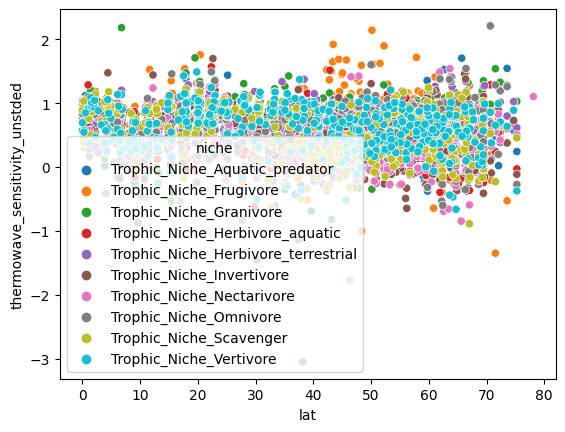

In [105]:
sns.scatterplot(
    data = sensitivity_df,
    x = 'lat',
    y = 'thermowave_sensitivity_unstded',
    hue='niche'
)

/tmp/ipykernel_17623/803921624.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data['latitude'] = data.set_index('h3_02').h3.h3_to_geo_boundary().geometry.centroid.y.values
/tmp/ipykernel_17623/803921624.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data['longitude'] = data.set_index('h3_02').h3.h3_to_geo_boundary().geometry.centroid.x.values
/tmp/ipykernel_17623/803921624.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silenc

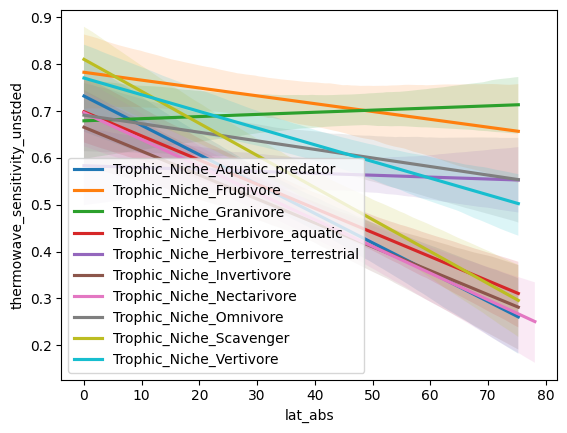

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt
import h3pandas

def reg_coef(df):
    import statsmodels.api as sm
    df = df.dropna(subset=['thermowave_sensitivity_unstded','lat_abs'])
    model = sm.OLS(df['thermowave_sensitivity_unstded'], sm.add_constant(df['lat_abs'])).fit()
    model = model.get_robustcov_results()
    return model.params[1]

data = sensitivity_df
data['latitude'] = data.set_index('h3_02').h3.h3_to_geo_boundary().geometry.centroid.y.values
data['longitude'] = data.set_index('h3_02').h3.h3_to_geo_boundary().geometry.centroid.x.values
data['lat_abs'] = data['latitude'].abs()
data.groupby(['niche']).apply(reg_coef)

for niche in data['niche'].unique():
    tmptmp = data[data['niche']==niche]
    sns.regplot(tmptmp['lat_abs'], tmptmp['thermowave_sensitivity_unstded'], 
                scatter=False,
                scatter_kws={'s':0.2,'alpha':0.2}, label=niche)

plt.legend()
plt.show()


## Check whether frequentist way the Europe mismatch also increase with latitude


In [121]:
import glob
all_niche_list = glob.glob('../../data/D03.greentrace_thermotrace/Trophic_Niche_*_10_40_20_50_curve_query.csv')
all_niche_list = [i.split('thermotrace/')[-1].split('_10_40')[0] for i in all_niche_list]
all_niche_list

['Trophic_Niche_Scavenger',
 'Trophic_Niche_Nectarivore',
 'Trophic_Niche_Invertivore',
 'Trophic_Niche_Granivore',
 'Trophic_Niche_Herbivore_terrestrial',
 'Trophic_Niche_Herbivore_aquatic',
 'Trophic_Niche_Omnivore',
 'Trophic_Niche_Frugivore',
 'Trophic_Niche_Vertivore',
 'Trophic_Niche_Aquatic_predator']

In [122]:
all_comb_list = []
for niche in all_niche_list:
    
    season = 'spring'
    comb = pd.read_csv(f'../../data/D03.greentrace_thermotrace/{niche}_10_40_20_50_curve_query.csv')
    comb = comb[comb['season']=='spring']

    try:
        del comb['geometry']
    except:
        pass
    comb = comb.set_index('h3_02').h3.h3_to_geo_boundary().reset_index(drop=False)
    comb = comb[comb.area<200]

    ######## 
    comb['BirdWave_mean_DOY'] = comb['mean_DOY_peak']
    comb['BirdWave_std_DOY'] = comb['std_DOY_peak']
    comb['GreenWave_mean_DOY'] = comb[f'Exp_{season}_DOY_by_delta_NDVI']
    comb['Temp_mean_DOY'] = comb[f'Exp_{season}_DOY_by_tmean']
    comb = comb.dropna(subset=['GreenWave_mean_DOY','Temp_mean_DOY'])

    def get_centered_GreenWave_mean_DOY(df):
        # print(df)
        df['centered_GreenWave_mean_DOY'] = df['GreenWave_mean_DOY']-df['GreenWave_mean_DOY'].mean()
        return df

    def get_centered_Temp_mean_DOY(df):
        df['centered_Temp_mean_DOY'] = df['Temp_mean_DOY']-df['Temp_mean_DOY'].mean()
        return df

    comb = comb.groupby(['h3_02']).apply(get_centered_GreenWave_mean_DOY, include_groups=False).reset_index(drop=False)
    del comb['level_1']
    comb = comb.groupby(['h3_02']).apply(get_centered_Temp_mean_DOY, include_groups=False).reset_index(drop=False)
    del comb['level_1']
    comb['niche'] = niche
    all_comb_list.append(comb)

all_comb = pd.concat(all_comb_list, axis=0).reset_index(drop=True)
del all_comb_list


/tmp/ipykernel_17623/1386377774.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  comb = comb[comb.area<200]
/tmp/ipykernel_17623/1386377774.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  comb = comb[comb.area<200]
/tmp/ipykernel_17623/1386377774.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  comb = comb[comb.area<200]
/tmp/ipykernel_17623/1386377774.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  comb = comb[comb.area<200]
/tmp

In [123]:
all_comb = all_comb[(all_comb['lat']>0) & (all_comb['lng']>=-30) & (all_comb['lng']<=50)]
all_comb['lat_abs'] = all_comb['lat'].abs()


In [124]:
res = all_comb.groupby(['h3_02','niche','lat','lng'])['mean_DOY_peak'].std().reset_index(drop=False)
res = res.rename(columns={'mean_DOY_peak':'variation_of_mean_DOY_peak'})


/beegfs/store4/chenyangkang/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


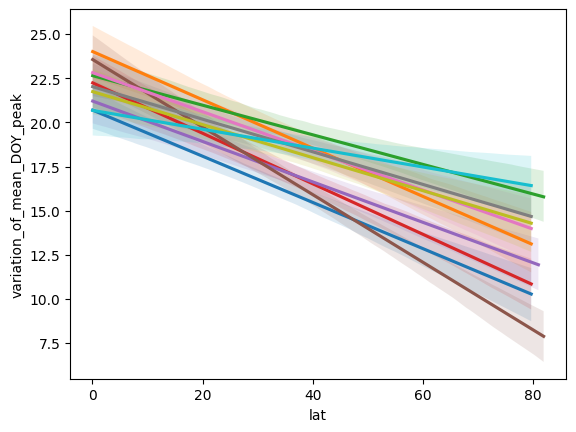

In [125]:
for niche in res.niche.unique():
    tmp = res[res['niche']==niche]
    # tmp = tmp[tmp['lat']>=25]
    sns.regplot(tmp['lat'], tmp['variation_of_mean_DOY_peak'], 
                scatter=False,
                scatter_kws={'s':0.2,'alpha':0.2}, label=niche)


In [126]:
# Calc thermowave sensitivity
def calc_sensitivity(tmp):
    import statsmodels.api as sm
    tmp = tmp.dropna(subset=['Exp_spring_DOY_by_tmean','mean_DOY_peak'])
    if len(tmp)<5:
        return None
    X = sm.add_constant(tmp['Exp_spring_DOY_by_tmean'])
    y = tmp['mean_DOY_peak']
    model = sm.OLS(y, X).fit()
    res = model.get_robustcov_results()
    return res.params[1]


In [127]:
res = all_comb.groupby(['niche','h3_02','lng','lat']).apply(calc_sensitivity).reset_index(drop=False)
res = res.rename(columns={0:'thermowave_sensitivity_unstded'})


/tmp/ipykernel_17623/1001841473.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res = all_comb.groupby(['niche','h3_02','lng','lat']).apply(calc_sensitivity).reset_index(drop=False)


In [128]:
res = res.dropna()
sensitivity_df = res


In [130]:
sensitivity_df

,niche,h3_02,lng,lat,thermowave_sensitivity_unstded
0,Trophic_Niche_Aquatic_predator,820027fffffffff,29.600681,77.193999,0.835626
1,Trophic_Niche_Aquatic_predator,82002ffffffffff,22.595539,79.658404,0.863000
3,Trophic_Niche_Aquatic_predator,820127fffffffff,24.357445,70.694569,0.765689
4,Trophic_Niche_Aquatic_predator,820137fffffffff,32.293493,70.320314,0.772574
5,Trophic_Niche_Aquatic_predator,820157fffffffff,17.015119,77.281855,1.207709
...,...,...,...,...,...
4993,Trophic_Niche_Vertivore,827aeffffffffff,39.418718,4.927247,0.439713
4994,Trophic_Niche_Vertivore,827af7fffffffff,44.232344,5.482530,0.370218
4995,Trophic_Niche_Vertivore,828287fffffffff,14.115048,1.527281,1.064703
4998,Trophic_Niche_Vertivore,82829ffffffffff,13.898732,4.279475,0.763952


<Axes: xlabel='lat', ylabel='thermowave_sensitivity_unstded'>

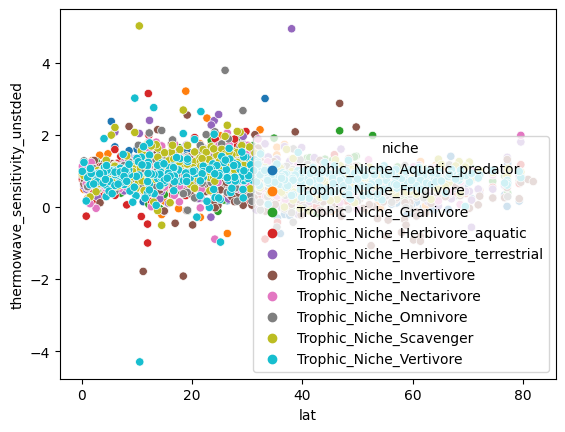

In [129]:
sns.scatterplot(
    data = sensitivity_df,
    x = 'lat',
    y = 'thermowave_sensitivity_unstded',
    hue='niche'
)

/tmp/ipykernel_17623/803921624.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data['latitude'] = data.set_index('h3_02').h3.h3_to_geo_boundary().geometry.centroid.y.values
/tmp/ipykernel_17623/803921624.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data['longitude'] = data.set_index('h3_02').h3.h3_to_geo_boundary().geometry.centroid.x.values
/tmp/ipykernel_17623/803921624.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silenc

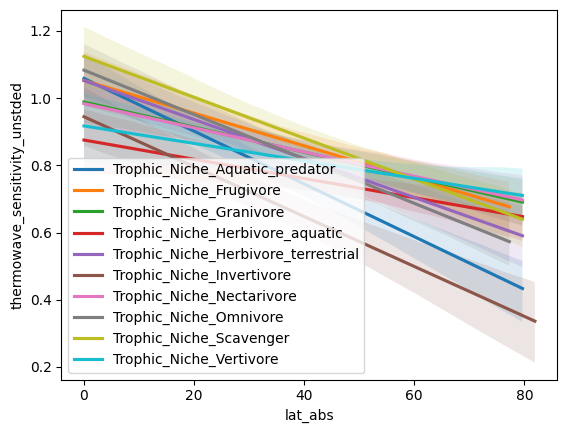

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt
import h3pandas

def reg_coef(df):
    import statsmodels.api as sm
    df = df.dropna(subset=['thermowave_sensitivity_unstded','lat_abs'])
    model = sm.OLS(df['thermowave_sensitivity_unstded'], sm.add_constant(df['lat_abs'])).fit()
    model = model.get_robustcov_results()
    return model.params[1]

data = sensitivity_df
data['latitude'] = data.set_index('h3_02').h3.h3_to_geo_boundary().geometry.centroid.y.values
data['longitude'] = data.set_index('h3_02').h3.h3_to_geo_boundary().geometry.centroid.x.values
data['lat_abs'] = data['latitude'].abs()
data.groupby(['niche']).apply(reg_coef)

for niche in data['niche'].unique():
    tmptmp = data[data['niche']==niche]
    sns.regplot(tmptmp['lat_abs'], tmptmp['thermowave_sensitivity_unstded'], 
                scatter=False,
                scatter_kws={'s':0.2,'alpha':0.2}, label=niche)

plt.legend()
plt.show()


The global one is probably ok!

Works! So 